# Tutorial 2: Expressions containing NDArray objects

Python-Blosc2 implements a powerful way to operate with NDArray arrays and other objects, called "lazy expressions".  A lazy expression is a lightweight object which stores a desired computation symbolically, with references to its operands (stored on disk or in memory), but does not execute until data is explicitly requested, e.g. if a slice of the computation result is requested. The lazy expression will then execute, but only on the necessary portion of the data, making it especially efficient, and avoiding large in-memory computations.

In this tutorial, we will see how to do such lazy computations, which are especially useful when working with large arrays, owing to this avoidance of costly in-memory temporaries.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import blosc2
import time
import psutil
import os
%matplotlib ipympl

# --- Memory profiler ---
def getmem():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

## Part 1) A simple example
First, let's create a couple of NDArray arrays. We're going to write them to disk since in principle we are interested in large arrays (so big that they can't fit in memory).

In [2]:
shape1 = (500, 10000)
shape2 = (10, 500, 10000)
a = blosc2.linspace(0, 1, np.prod(shape1), dtype=np.float32, shape=shape1, urlpath="a.b2nd", mode="w")
b = blosc2.linspace(1, 2, np.prod(shape2), dtype=np.float64, shape=shape2, urlpath="b.b2nd", mode="w")

Now let's define a lazy expression, which can be defined via two different APIs (which are exactly equivalent).

In [3]:
# Now, let's create an expression that involves `a` and `b`, called `c`.
c = a**2 + b**2 + 2 * a * b + 1
print('With direct definition')
print(c.info)  # at this stage, the expression has not been computed yet

# We can also define a lazyexpr like so
c_string = blosc2.lazyexpr('a**2 + b**2 + 2 * a * b + 1')
print('With string-based constructor')
print(c_string.info)  # at this stage, the expression has not been computed yet

With direct definition
type       : LazyExpr
expression : ((((o0 ** 2) + (o1 ** 2)) + ((2 * o0) * o1)) + 1)
operands   : {'o0': 'a.b2nd', 'o1': 'b.b2nd'}
shape      : (10, 500, 10000)
dtype      : float64

With string-based constructor
type       : LazyExpr
expression : (o0 ** 2 + o1 ** 2 + 2 * o0 * o1 + 1)
operands   : {'o0': 'a.b2nd', 'o1': 'b.b2nd'}
shape      : (10, 500, 10000)
dtype      : float64



We see that, for either API, the type of `c` is a `LazyExpr` object. We'll ignore the string-based constructor for the rest of this tutorial.

A ``LazyExpr`` object is a placeholder for the actual computation that will be done when we compute the expression.  This is a very powerful feature because it allows us to build complex expressions without actually computing anything until we really need the result (or a portion of the result).

Moreover, we can access the individual metadata of the result (such as ``shape`` and `dtype`) as attributes of the lazy expression ``c`` rapidly, without computing anything. Time how long it takes (using the cell magic ``%time`` or line magic ``%%timeit``).

In [4]:
%time
print(f'Shape of operands: a - {a.shape}, b - {b.shape}')
print(f'Shape of result = {c.shape}')
print(f'dtype = {c.dtype}')

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 4.05 μs
Shape of operands: a - (500, 10000), b - (10, 500, 10000)
Shape of result = (10, 500, 10000)
dtype = float64


Before moving on, note that the shapes of `a` and `b` are different. However, the shapes are compatible, and so Blosc2 applies **broadcasting** (à la NumPy) efficiently, both to obtain the precomputation metadata (very fast) as well as to perform the computation (slower). 

Now, let's see all this in action in computation. `LazyExpr` objects follow the [LazyArray interface](../../reference/lazyarray.html), and this provides several ways for performing the computation, depending on the object we want as the desired output.

#### 1. Returning a NDArray array
**i) Computing an expression** First, let's use the `compute` method. The result will be another NDArray array, which will be compressed and so very storage efficient:

In [5]:
m0 = getmem() #initial memory used
t0 = time.time()
d = c.compute()
print(f"Computation time {round((time.time() - t0)*1000,1)} ms")
print(f"Memory used {round(getmem() - m0)} MB")
print(f"Class: {type(d)}, occupies {round(d.cbytes / 1024 ** 2)} MB. Compression ratio {d.cratio:.2f}x")
del d

Computation time 224.4 ms
Memory used 236 MB
Class: <class 'blosc2.ndarray.NDArray'>, occupies 150 MB. Compression ratio 2.54x


Note that just accessing metadata via e.g. ``c.shape`` took much less time, since it uses the metadata of the operands (plus broadcasting and casting rules) to determine the shape, dtype etc. of the result.

**ii) Write to disk** We can in fact write the result direct to disk. 

**EXERCISE**: ``compute`` accepts the same kwargs (in particular ``urlpath`` and ``mode``) as the NDArray constructors from the previous tutorial. Write the result to a disk as ``result.b2nd`` and examine the time and memory consumption compared to the case in **i)** above. In principle, no memory is used at all since operands and result are all on disk (why is some memory still used? why is the time taken longer than in **i)**?).

In [6]:
## PROFILE (TIME AND MEMORY) THIS LINE
d = c.compute(urlpath='result.b2nd', mode ='w')

In [7]:
del d
## Check that the result has been written to disk
!ls -lh result.b2nd

-rw-rw-r-- 1 lshaw lshaw 151M ago 18 11:29 result.b2nd


**iiI) Computing slices** We can also compute just a slice of the result.

**EXERCISE**: Look at the documentation of ``compute`` and try to calculate the slice of the result ``slice(2, 200, 25)`` and examine memory consumption and execution time as above. Why is the calculation much faster?
Consider what would happen with a plain NumPy calculation - how could you get a slice of the result faster than calculating the whole result and then slicing?

In [8]:
## PROFILE (TIME AND MEMORY) OF SLICING

What is happening when we call the ``compute`` method? The operands are all NDArray arrays, chunked and stored on disk. When the compute method is called, the expression is executed, chunk-by-chunk, and the result stored, chunk-by-chunk. Hence at any given time, only a small amount of data (a chunk for each operand and the result) must be operated on in memory. The result may be written to memory, chunk-by-chunk, but it is just as easy  (see **ii) Writing to Disk**) to write straight to disk - hence you can operate with very large arrays in a very small memory footprint (a handful of chunks). Moreover, the computation is only performed on the necessary chunks required to give the result slice (see **iii) Computing slices**).



#### 2. Returning a NumPy array
Now, let's compute the expression and store the result in a NumPy array.  For this, we will use the `__getitem__` method of the ``LazyExpr`` ``c``; recall that in the previous tutorial `__getitem__` (i.e. ``arr[1:,4], arr[slice(1,10,1)]``) also returned a NumPy array (from decompressing a Blosc2 NDArray). The syntax is the same.

**EXERCISE**: As we did above, examine the memory consumption, execution time and total space occupied by the result when one returns a NumPy array from a lazy expression - both for a) the full result (i.e. ``c[:]``) and b) the slice ``slice(2, 200, 25)``. Check the types and shapes of the resulting arrays. What do you notice about memory, time and storage? Does it all make sense?

In [9]:
# a) compute the full expression and profile it
# YOUR CODE HERE
print(f"Class: {type(d)}, occupies {round(np.prod(d.shape) * d.itemsize / 1024 ** 2)} MB") # total space occupied

# b) compute a slice of the expression and profile it
#YOUR CODE HERE
print(f"Class: {type(d)}, occupies {round(np.prod(d.shape) * d.itemsize / 1024 ** 2)} MB") # total space occupied

NameError: name 'd' is not defined

As you can see, in either case the result is a NumPy array now.

#### Summary
Depending on your needs, you can choose to get the result as a NDArray array or as a NumPy array.  The former is more storage efficient, but the latter is more flexible when interacting with other libraries that do not support NDArray arrays, or for reading out data.

**Note: Functions**
Lazy expressions also support many standard functions (essentially those available in NumPy), such as `sin`, `cos`, `exp`, `log`, etc. as well as reductions like ``sum``, ``mean`` etc.


In [10]:
lexpr = blosc2.sin(a) + blosc2.exp(b)
print(f'lexpr of type : {type(lexpr)} of shape {lexpr.shape} and dtype {lexpr.dtype}')
blosc_res = lexpr.compute(item = 5)
np_res = lexpr[5]
print(f'blosc_res of type {type(blosc_res)}, np_res of type {type(np_res)}')
print(f'blosc_res of shape {blosc_res.shape}, np_res of shape {np_res.shape}')

lexpr of type : <class 'blosc2.lazyexpr.LazyExpr'> of shape (10, 500, 10000) and dtype float64
blosc_res of type <class 'blosc2.ndarray.NDArray'>, np_res of type <class 'numpy.ndarray'>
blosc_res of shape (500, 10000), np_res of shape (500, 10000)


## Part 2) A more practical example

Ok, let's put the computation engine through its paces with some proper computations. We shall set up a 3D grid, represented by 3 1D arrays, and exploit broadcasting to reduce memory footprint.

In [33]:
# --- Experiment Setup ---
n_frames = 1000  # Raise this for more frames
width, height = np.array((n_frames, n_frames))  # Size of the grid
dtype = np.float64  # Data type for the grid

# --- Coordinate creation ---
x = blosc2.linspace(0, n_frames, n_frames, dtype=dtype)
y = blosc2.linspace(-4 * np.pi, 4 * np.pi, width, dtype=dtype)
z = blosc2.linspace(-4 * np.pi, 4 * np.pi, height, dtype=dtype)
X = blosc2.expand_dims(blosc2.expand_dims(x, 1), 2)  # Shape: (N, 1, 1)
Y = blosc2.expand_dims(blosc2.expand_dims(y, 0), 2)  # Shape: (1, N, 1)
Z = blosc2.expand_dims(blosc2.expand_dims(z, 0), 0)  # Shape: (1, 1, N)

Now lets define a computation result (in 3D) via a function - later on we shall plot it. We can in fact apply NumPy functions to the blosc2 NDArray arrays and the result will still be a lazyexpr.

**EXERCISE**: 

a) Execute ``expr = genexpr(X, Y, Z)`` and profile the memory consumption and execution time of this execution as above (both should be very low). Check the type of ``expr`` and access its metadata (``shape`` and ``dtype``). 

b) How much memory (uncompressed) should the result occupy (i.e. how many GB would ``expr[:]`` load into memory?)? If ``expr`` were an NDArray, one could do ``expr.nbytes`` but since it is a ``LazyExpr``, we cannot do this. Instead, you should be able to work this out just from the ``shape`` and ``dtype`` (HINT: Use the ``dtype.itemsize`` attribute?) metadata. The accessing of metadata in a) was instantaneous - if this required calculating the final result, do you think it would be as fast, given the size of the result?)

In [34]:
# --- Generate computed data ---
def genexpr(a, b, c):
    time_factor = a * b * 0.001
    R = np.sqrt(b**2 + c**2)
    theta = np.arctan2(c, b)
    return np.sin(R * 3 - time_factor * 2) * np.cos(theta * 3)

#a)
# Profile memory usage of 
expr = genexpr(X, Y, Z)
# YOUR CODE HERE

# Check type, shape and dtype of expr
# YOUR CODE HERE

#b) Calculate size of expr result
# YOUR CODE HERE

Now let's generate an animation which computes the expression slice-by-slice on-the-fly, using the ``LazyExpr`` ``__getitem__`` method:

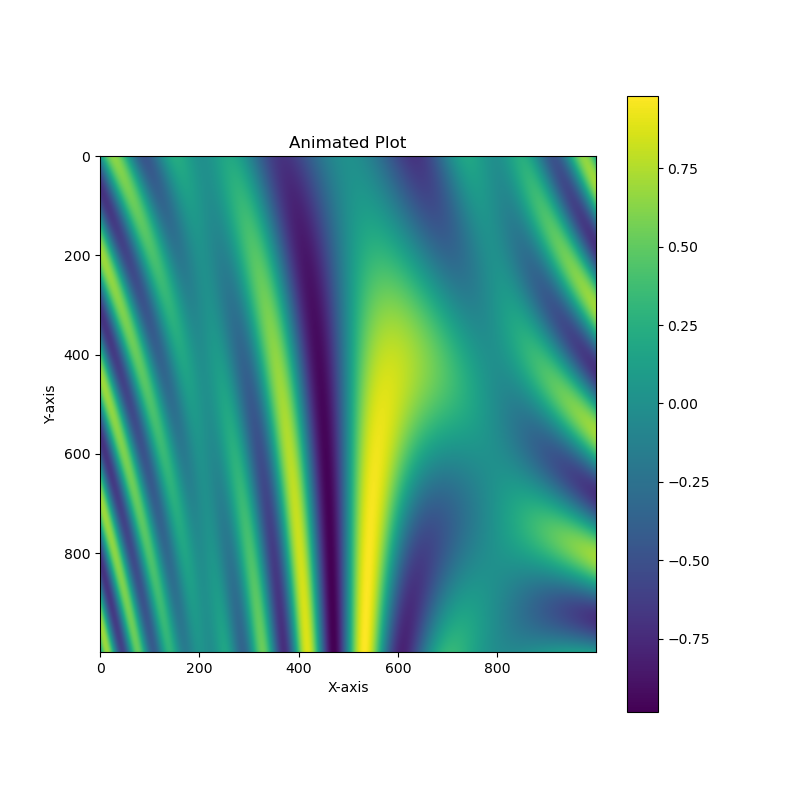

In [35]:
def create_video(arr):
    label = 'NumPy' if isinstance(arr, np.ndarray) else 'Blosc2'
    fig = plt.figure(figsize=(8, 8))
    a = arr[:,:,0]
    im = plt.imshow(a, cmap="viridis")
    fig.colorbar(im)
    plt.title("Animated Plot")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    start_time = time.time()
    def update(frame_num):
        # Evaluate the expression for the current frame on the fly
        a = arr[:, :, frame_num]  # <-------------- perform computation
        im.set_array(a)
        elapsed_time = time.time() - start_time
        plt.title(f"{label}: Frame {frame_num + 1}/{n_frames}, elapsed time = {round(elapsed_time, 2)} s")
        return im,
    ani = FuncAnimation(fig, update, frames=n_frames, interval=10, blit=False, repeat=False)
    plt.show()
    return ani

create_video(expr)


Ok! So our Blosc2 compute engine works well enough to be useful practically - most of the elapsed time is due to matplotlib rendering.

**EXERCISE**: 

Try to rerun the previous cell but replace the computations with just rendering an empty array - the time should be basically the same. Why might it be advantageous to compute slice-by-slice rather than precompute all frames and then access them?

Once you've done all this don't forget to change the``create_video`` function back to the original though!

#### Profiling lazy expressions
We now know that the lazy expression machinery is fast enough to be useful. Now we are going to compare memory usage and computation time to NumPy. In order to do that, we should define a helper function which profiles the ``__getitem__`` method of the lazy expression (which returns a NumPy array) and the NumPy computation.

In [36]:
# --- Run computation and profile time and memory usage ---
def monitor(BLOSC=True):
    m0 = getmem()
    t0 = time.time()
    expr = genexpr(X, Y, Z)[:] if BLOSC else genexpr(X[:], Y[:], Z[:])
    dt = time.time()-t0
    if dt > 1e-3:
        print(f'Operation took {round(dt, 3)} s')
    else:
        print(f'Operation took {round(dt * 1000_000, 1)} μs')
    print(f'Result occupies {round((getmem()-m0))} MB')
    return expr

Now let's actually do the computation for the lazy expression, for all frames, and see how the memory usage compares to that of the plain NumPy computation.

**EXERCISE** 

a) Use the ``monitor`` function to profile the Blosc2 lazy expression computation (``genexpr(X, Y, Z)[:]``) and check the type and nbytes of the result.

In [37]:
print('Profile Blosc2....')
result = monitor()
# YOUR CODE HERE

Profile Blosc2....
Operation took 2.307 s
Result occupies 7631 MB


b) Delete the result and now use the ``monitor`` function to profile the plain NumPy calculation (``genexpr(X[:], Y[:], Z[:])``) and again check the type and nbytes of the result (both should be the same).

In [38]:
del result
print('--------\nProfile NumPy....')
expr = monitor(False)
# YOUR CODE HERE

--------
Profile NumPy....
Operation took 7.178 s
Result occupies 7630 MB


Blosc2, owing to chunking and caching, makes more effective use of machine architecture, so it actually runs faster in practice!

## Summary

In this section, we have seen how to perform computations with NDArray arrays: how to create lazy expressions, compute them, and save them to disk. Also, we have looked at performing reductions, broadcasting and heavy computations. Lazy expressions allow you to build and compute complex computations from operands that can be in-memory, on-disk or remote (see [`C2Array`](reference/c2array.html)) in a simple and effective way.

In [ ]:
# cleanup
blosc2.remove_urlpath("a.b2nd")
blosc2.remove_urlpath("b.b2nd")
blosc2.remove_urlpath("result.b2nd")